In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import make_train_val_test, errors_distribution

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import json
import datetime
import seaborn as sns
import csv
sns.set()
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import initializers

import os
import time

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4717513841743271006,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4791656221561757945
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6256670816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10096942379089247576
 physical_device_desc: "device: 0, name: GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7594922879926913677
 physical_device_desc: "device: XLA_GPU device"]

In [20]:
df_i = pd.read_pickle(f'{root_project}/data/processed/features_model_rev5.pickle')
df_i

,i_country,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_infected,total_death,total_removed,betweenness,degree,closeness,country_pop
0,LBN,9.490802,2.214174,21.014286,0.069029,2918.571429,114.077951,0.007146,0.005701,0.048225,72,6,23,7.509688e+09,5.191675e+08,7.521476e+09,0.001057,0.270270,0.460581,6848925.0
1,KIR,3.161672,6.111805,19.323523,0.012080,126501.000000,291.642242,0.003715,0.002368,0.007072,872,2,2,7.166248e+09,8.694994e+07,7.201020e+09,0.000956,0.036036,0.391534,115847.0
2,MOZ,16.439975,1.263448,20.771054,0.046275,80454.071429,2297.546954,0.002847,0.001771,0.026642,192,0,22,7.530737e+09,3.532065e+08,7.633573e+09,0.000059,0.054054,0.382759,29495962.0
3,ERI,2.141326,1.149404,2.461249,0.014779,5593.642857,196.917492,0.006883,0.009034,0.010026,511,9,28,6.401541e+09,9.461014e+07,6.402090e+09,0.000007,0.049550,0.368159,3213972.0
4,VCT,9.327237,1.192357,11.121400,0.058201,9880.857143,286.248927,0.013316,0.013809,0.044225,958,18,20,7.477989e+09,4.352523e+08,7.478614e+09,0.000035,0.040541,0.312236,110210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279990,SGP,18.473903,1.031939,19.063932,0.867346,17242.500000,8752.775510,0.047399,0.026678,0.453940,183,9,7,7.503800e+09,6.508834e+09,7.504311e+09,0.013456,0.360360,0.509174,5638676.0
279991,CIV,15.657956,0.799619,12.520400,0.965765,85400.000000,49171.770833,0.062628,0.031725,0.448804,63,15,4,2.503739e+07,2.418014e+07,2.503729e+07,0.000908,0.166667,0.419660,25069229.0
279992,ARE,3.729777,3.696492,13.787093,0.619548,28.642857,11.933333,0.152120,0.170391,0.465649,110,3,5,1.121218e+07,6.946411e+06,1.121216e+07,0.055779,0.806306,0.608219,9630959.0
279993,LAO,7.372083,1.849250,13.632825,0.701566,378.928571,217.193548,0.094251,0.074261,0.473037,496,11,8,6.538427e+09,4.590038e+09,6.542575e+09,0.000000,0.063063,0.375635,7061507.0


In [6]:
# df = df.sample(5000) # par entrenar con menos muestras

features = ['Tr', 'inf_pow_1', 'inf_pow_2', 'mort_pow_1', 'mort_pow_2', 'mort_pow_3', 'limit_deaths',
           'n_closed', 'react_time','total_death', 'betweenness', 'degree', 'closeness', 'country_pop']

df = df_i[features]

display(df)

X_train, X_val, X_test, y_train, y_val, y_test = make_train_val_test(df, out_mode=0)

size_data = int(len(X_train) / 1000)
num_features= len(X_train.columns)

,Tr,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_death,betweenness,degree,closeness,country_pop
0,21.014286,2918.571429,114.077951,0.007146,0.005701,0.048225,72,6,23,5.191675e+08,0.001057,0.270270,0.460581,6848925.0
1,19.323523,126501.000000,291.642242,0.003715,0.002368,0.007072,872,2,2,8.694994e+07,0.000956,0.036036,0.391534,115847.0
2,20.771054,80454.071429,2297.546954,0.002847,0.001771,0.026642,192,0,22,3.532065e+08,0.000059,0.054054,0.382759,29495962.0
3,2.461249,5593.642857,196.917492,0.006883,0.009034,0.010026,511,9,28,9.461014e+07,0.000007,0.049550,0.368159,3213972.0
4,11.121400,9880.857143,286.248927,0.013316,0.013809,0.044225,958,18,20,4.352523e+08,0.000035,0.040541,0.312236,110210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279990,19.063932,17242.500000,8752.775510,0.047399,0.026678,0.453940,183,9,7,6.508834e+09,0.013456,0.360360,0.509174,5638676.0
279991,12.520400,85400.000000,49171.770833,0.062628,0.031725,0.448804,63,15,4,2.418014e+07,0.000908,0.166667,0.419660,25069229.0
279992,13.787093,28.642857,11.933333,0.152120,0.170391,0.465649,110,3,5,6.946411e+06,0.055779,0.806306,0.608219,9630959.0
279993,13.632825,378.928571,217.193548,0.094251,0.074261,0.473037,496,11,8,4.590038e+09,0.000000,0.063063,0.375635,7061507.0


Train set: (167997, 13)
Validation set: (55999, 13)
Test set: (55999, 13)


In [7]:
num_columns = X_train.columns

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns].astype(np.float64))
X_val_scaled = scaler.transform(X_val[num_columns].astype(np.float64))
X_test_scaled = scaler.transform(X_test[num_columns].astype(np.float64))

# oh = OneHotEncoder(handle_unknown='ignore')
# X_train_scaled = np.hstack((X_train_scaled, oh.fit_transform(X_train[cat_columns]).toarray()))
# X_test_scaled = np.hstack((X_test_scaled, oh.transform(X_test[cat_columns]).toarray()))

# scaler = StandardScaler()
# y_train = scaler.fit_transform(np.expand_dims(y_train.astype(np.float64),axis=1))
# y_test = scaler.transform(np.expand_dims(y_test.astype(np.float64),axis=1))

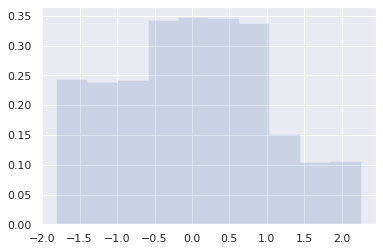

In [8]:
fig, ax = plt.subplots(1, 1)
ax.hist(X_train_scaled[:,0], density=True, histtype='stepfilled', alpha=0.2)
plt.show()

In [9]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [10]:
# import shutil
# shutil.rmtree('/content/drive/My Drive/TFM/archivos_colab/my_logs')

In [11]:
# root_logdir_tensorboard = '/content/drive/My Drive/TFM/archivos_colab/my_logs'
# root_logdir_checkpoints = '/content/drive/My Drive/TFM/archivos_colab/checkpoints'

root_logdir_tensorboard = f"{root_project}/models/my_logs"
root_logdir_checkpoints = f"{root_project}/models/checkpoints"

In [12]:
# dense_layers = [5, 4, 6]
# layer_sizes = [80, 40, 70, 90]


dense_layers = [7]
layer_sizes = [120]

revision = '13'

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        time.sleep(10)
        run_time = time.strftime("run_%d_%m_%Y-%H_%M_%S")
        NAME = f"{dense_layer}-layers-{layer_size}-nodes-{size_data}k-samples-{num_features}-feat-rev{revision}-{run_time}"
        print(NAME)
        model = Sequential()
        inputs = Input(X_train_scaled.shape[1:])
        
        for l in range(dense_layer-1):
            model.add(Dense(layer_size, activation='selu', kernel_initializer='lecun_normal'))
        
        model.add(Dense(1))
        
        tensorboard_cb = keras.callbacks.TensorBoard(f"{root_logdir_tensorboard}/{NAME}")
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
        checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=f"{root_logdir_checkpoints}/{NAME}",
                                                       save_best_only=True, verbose=1)

        # model.compile(optimizer=Nadam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
        model.compile(optimizer=Nadam(), loss='mean_squared_error',
                      metrics=['mean_absolute_error', coeff_determination])

        
        history = model.fit(X_train_scaled, y_train, epochs=500, verbose=0,
                            validation_data=(X_val_scaled, y_val),
                           callbacks=[tensorboard_cb, early_stopping_cb, checkpoint_cb])

        score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
        score_test = model.evaluate(X_val_scaled, y_val, verbose=0)
        
        to_csv = [NAME, score_test[0], score_test[1], score_test[2]]
        
        with open(f"{root_project}/models/result_models.csv", mode='w') as results_file:
            model_writer = csv.writer(results_file, delimiter=',')
            model_writer.writerow(to_csv)
        
        print('Train score:', score_train[0])
        print('Train MAE:', score_train[1])
        print('Train r-squared:', score_train[2])
        print('Test score:', score_test[0])
        print('Test MAE:', score_test[1])
        print('Test r-squared:', score_test[2])
        print('========')

7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00

Epoch 00001: val_loss improved from inf to 125635833586778112.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00/assets

Epoch 00002: val_loss improved from 125635833586778112.00000 to 97124062559469568.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00/assets

Epoch 00003: val_loss improved from 97124062559469568.00000 to 81409653396733952.00000, saving m

INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00/assets

Epoch 00041: val_loss did not improve from 41580811048189952.00000

Epoch 00042: val_loss improved from 41580811048189952.00000 to 40861021774020608.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00/assets

Epoch 00043: val_loss did not improve from 40861021774020608.00000

Epoch 00044: val_loss did not improve from 40861021774020608.00000

Epoch 00045: val_loss did not improve from 40861021774020608.00000

Epoch 00046: val_loss improved from 40861021774020608.00000 to 39546650112294912.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samp


Epoch 00095: val_loss did not improve from 33216330026975232.00000

Epoch 00096: val_loss did not improve from 33216330026975232.00000

Epoch 00097: val_loss improved from 33216330026975232.00000 to 32901554021335040.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00/assets

Epoch 00098: val_loss improved from 32901554021335040.00000 to 32647609784991744.00000, saving model to /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00
INFO:tensorflow:Assets written to: /disks/hdd2T/Drive/TFM-master/models/checkpoints/7-layers-120-nodes-167k-samples-13-feat-rev12-run_26_08_2020-12_27_00/assets

Epoch 00099: val_loss did not improve from 32647609784991744.00000

Epoch 00100: val_loss did

In [13]:
# # para cargar un modelo

# NAME = '7-layers-120-nodes-137k-samples-13-feat-rev12-run_25_08_2020-11_20_42'

# model = load_model(f"{root_project}/models/checkpoints/{NAME}",
#                    custom_objects={'coeff_determination':coeff_determination})

# score_train = model.evaluate(X_train_scaled, y_train, verbose=0)
# score_test = model.evaluate(X_test_scaled, y_test, verbose=0)

# print('Train score:', score_train[0])
# print('Train MAE:', score_train[1])
# print('Train r-squared:', score_train[2])
# print('Test score:', score_test[0])
# print('Test MAE:', score_test[1])
# print('Test r-squared:', score_test[2])

Train score: 1.371401354173481e+17
Train MAE: 170026528.0
Train r-squared: 0.9394307136535645
Test score: 1.6519579809769062e+17
Test MAE: 179903584.0
Test r-squared: 0.9270995855331421


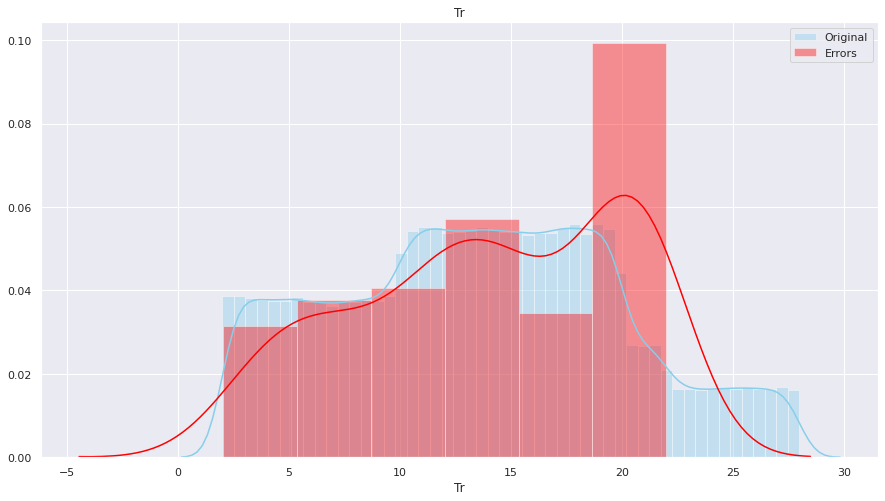

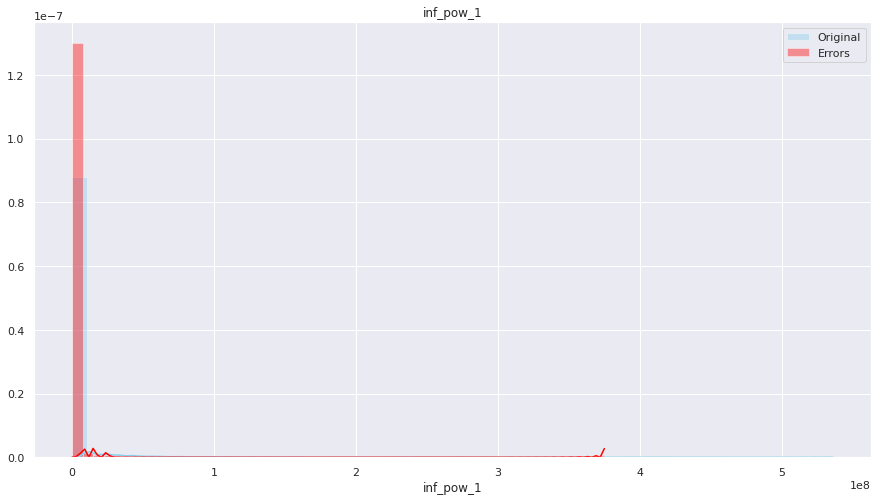

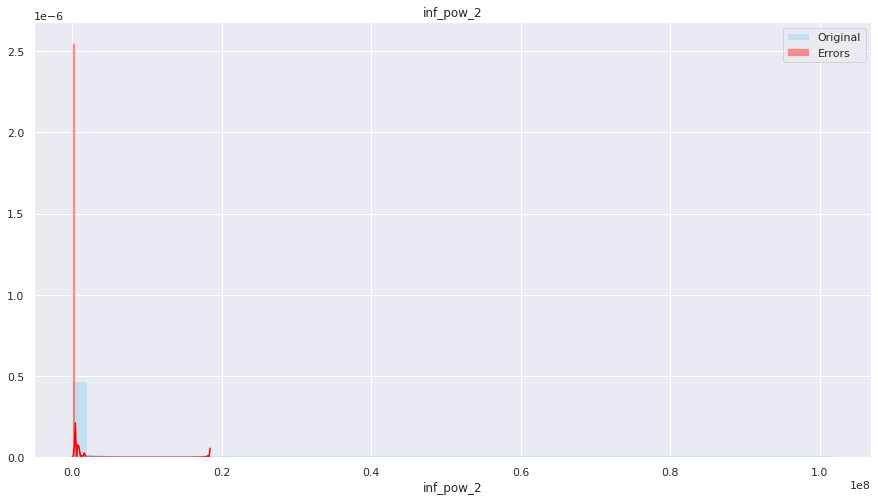

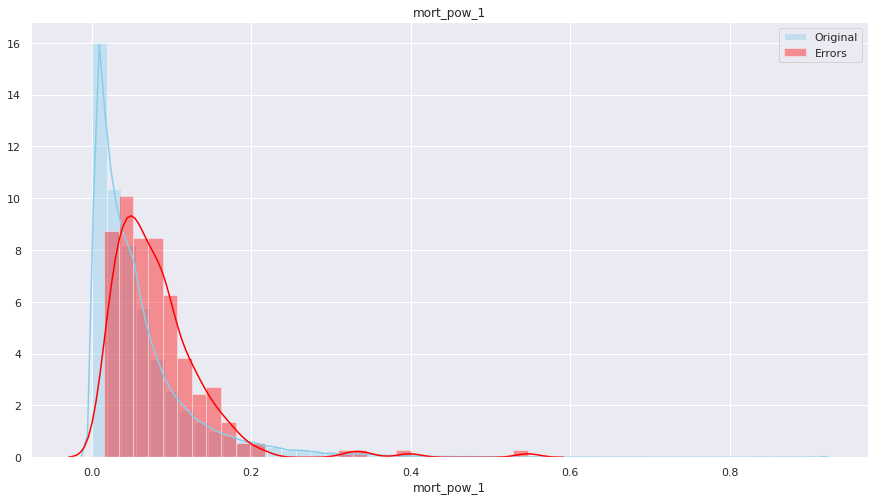

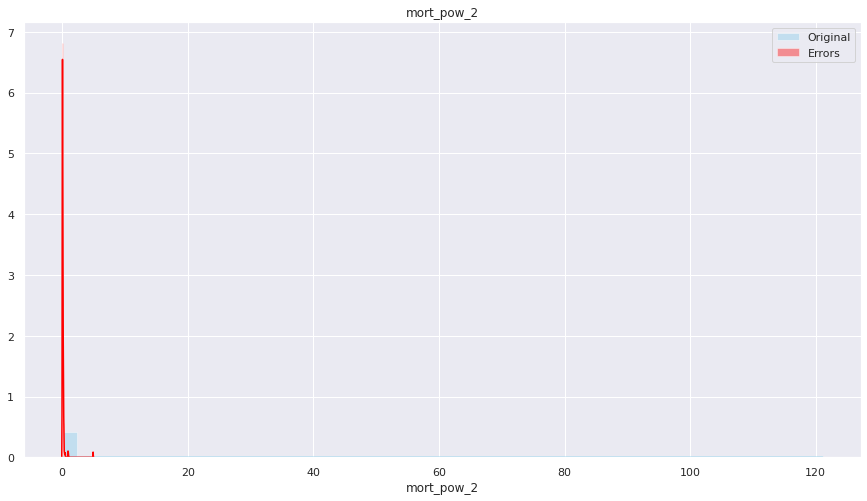

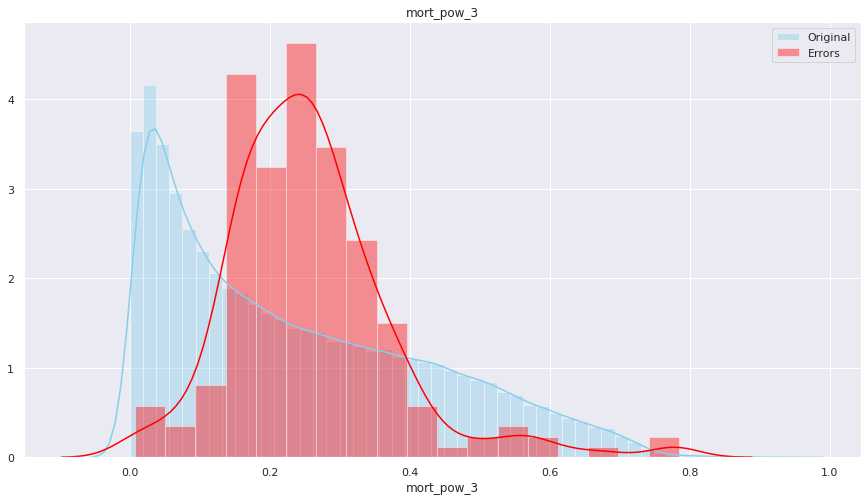

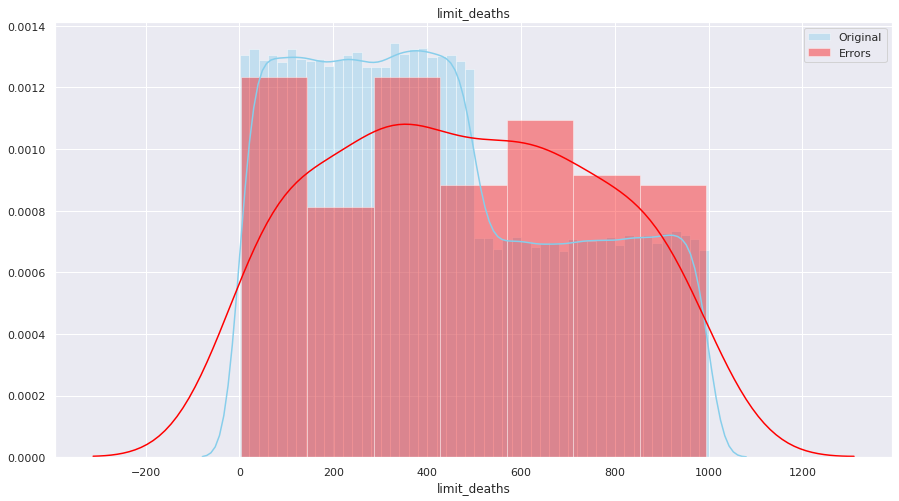

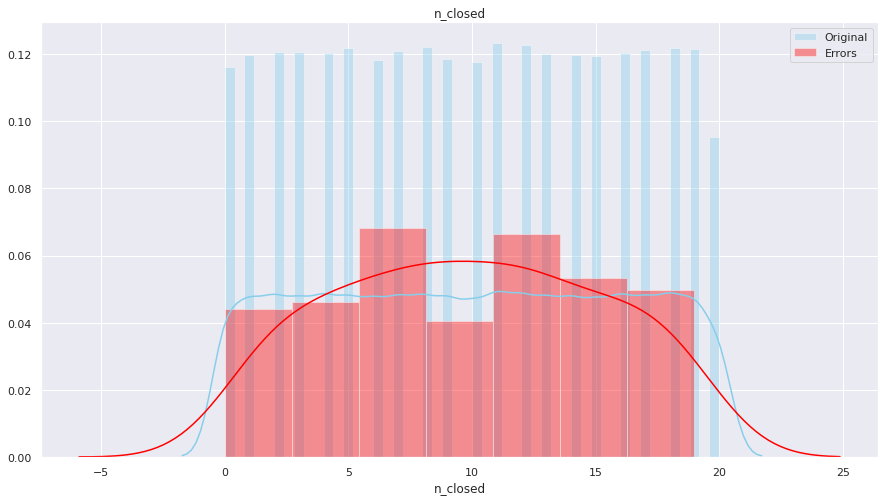

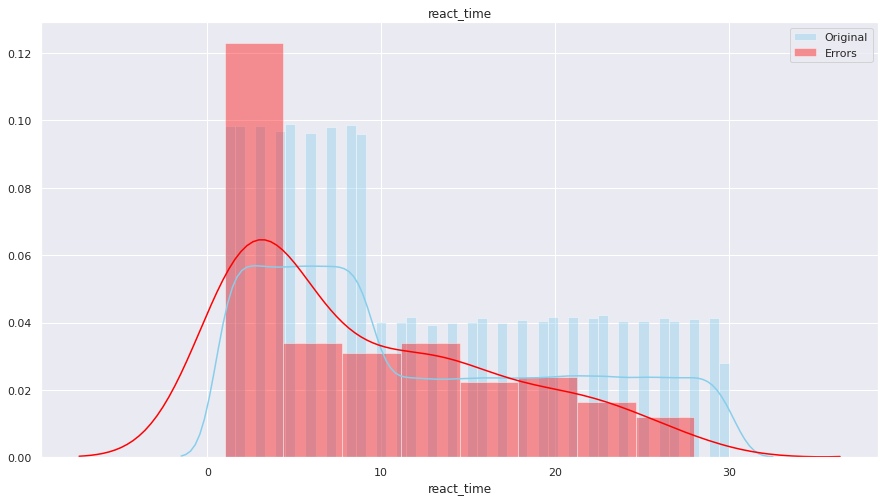

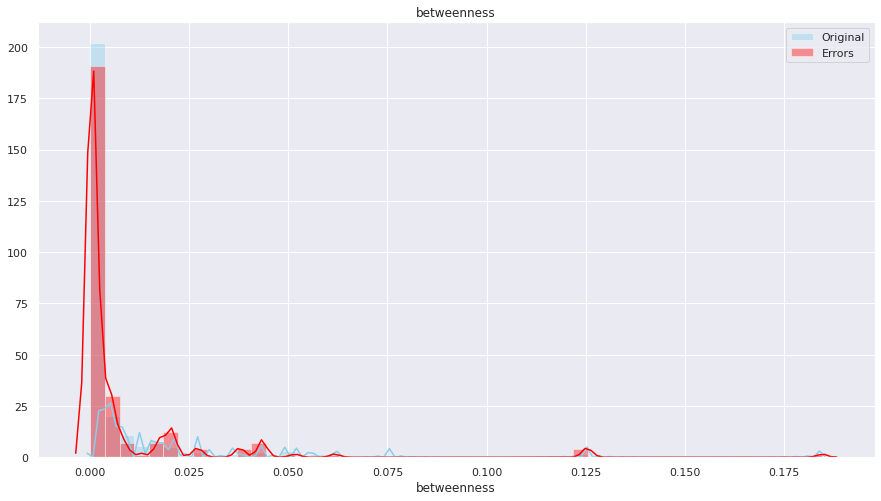

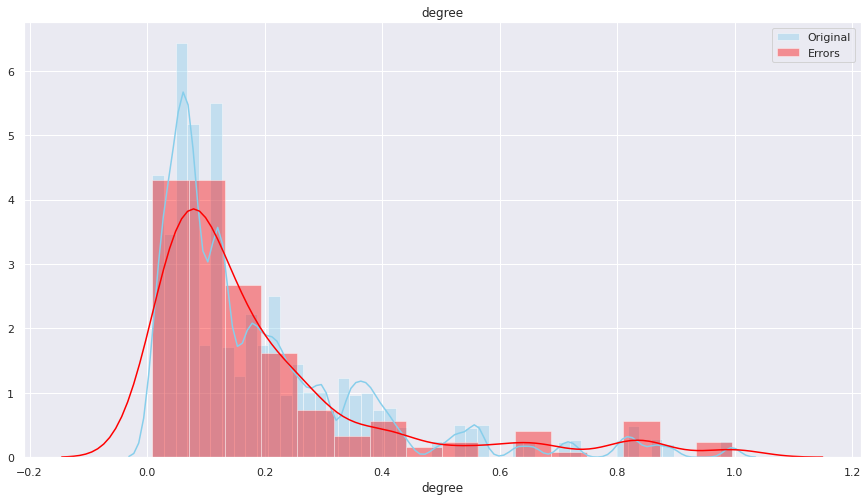

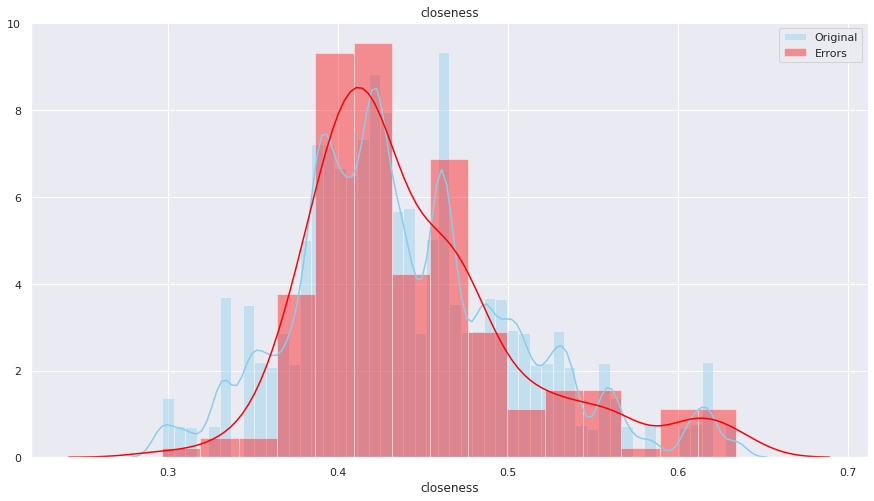

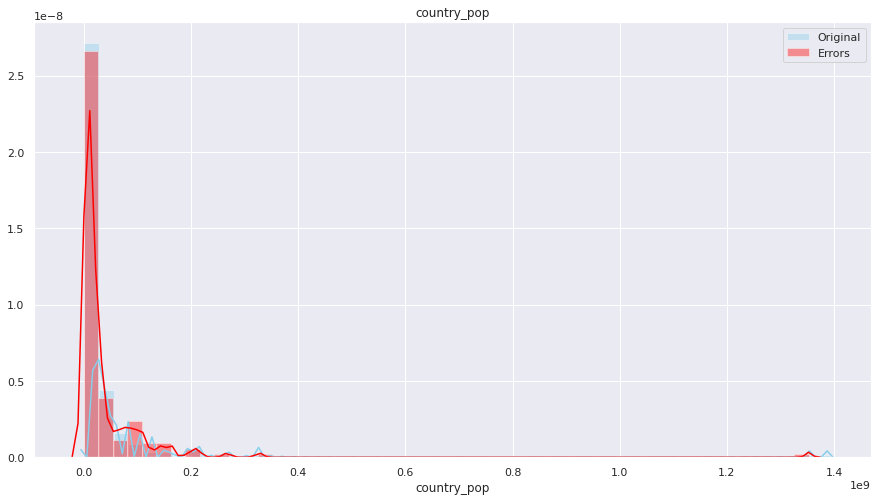

In [13]:
errors_distribution(model, X_test, y_test, X_train, n=200, X_test_scaled=X_test_scaled)

In [22]:
X_err = X_test.copy()
X_err['predicted'] = model.predict(X_test_scaled)

X_err['real'] = y_test
X_err['error'] = X_err['real'] - X_err['predicted']
X_err['abs_error'] = np.abs(X_err['error'])
X_err = X_err.sort_values(by='abs_error', ascending=False).iloc[:100]
error_idx = X_err.index

display(df_i.describe())
display(df_i.iloc[error_idx].describe())


,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_infected,total_death,total_removed,betweenness,degree,closeness,country_pop
count,279995.000000,279995.000000,279995.000000,279995.000000,2.799950e+05,2.799950e+05,279995.000000,279995.000000,279995.000000,279995.000000,279995.000000,279995.000000,2.799950e+05,2.799950e+05,2.799950e+05,279995.000000,279995.000000,279995.000000,2.799950e+05
mean,11.550309,1.604658,12.954083,0.271893,8.116446e+06,4.149086e+05,0.043510,0.050649,0.168164,456.960196,9.767824,13.377428,6.143541e+09,1.489217e+09,6.156413e+09,0.006620,0.193325,0.439722,3.648197e+07
std,5.534649,1.538821,6.201349,0.270504,4.207319e+07,2.839228e+06,0.058540,0.399540,0.172533,285.572327,5.909949,8.698240,2.304192e+09,1.712009e+09,2.310293e+09,0.019102,0.188811,0.065651,1.377037e+08
min,2.000118,0.091932,2.000186,0.000011,2.214286e+00,6.333333e-01,0.000003,0.000003,0.000007,1.000000,0.000000,1.000000,8.573000e+03,5.310000e+02,8.566000e+03,0.000000,0.009009,0.296395,1.164600e+04
25%,6.765894,0.663389,7.876078,0.061915,1.417929e+03,1.564986e+02,0.008569,0.006490,0.037750,214.000000,5.000000,6.000000,5.680016e+09,2.659946e+08,5.686510e+09,0.000058,0.063063,0.392920,1.136191e+06
50%,11.527176,1.114645,13.019244,0.157845,3.007357e+04,2.360373e+03,0.022658,0.018132,0.095877,425.000000,10.000000,12.000000,7.477440e+09,7.775347e+08,7.478861e+09,0.000554,0.126126,0.427746,6.982084e+06
75%,16.281376,1.932176,17.754410,0.419143,4.824258e+05,2.749078e+04,0.054720,0.045914,0.252233,699.000000,15.000000,21.000000,7.511905e+09,2.092795e+09,7.514188e+09,0.003897,0.252252,0.477419,2.554982e+07
max,21.999739,13.905995,27.999530,1.278734,5.362096e+08,1.017822e+08,0.912579,121.095781,0.935788,1000.000000,20.000000,30.000000,7.582232e+09,9.689799e+09,7.665912e+09,0.184702,0.995495,0.634286,1.392730e+09


,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_infected,total_death,total_removed,betweenness,degree,closeness,country_pop
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,8.450251,3.094990,14.453780,0.425621,4.439222e+05,4.882796e+04,0.095955,0.113379,0.283992,488.350000,9.550000,9.490000,3.001748e+09,1.328200e+09,3.003657e+09,0.008821,0.213919,0.449339,2.736750e+07
std,6.285413,2.587537,5.608380,0.169407,1.699234e+06,1.878587e+05,0.069985,0.122937,0.134806,291.902273,5.182283,7.737479,3.016513e+09,1.541119e+09,3.019126e+09,0.020376,0.233919,0.066710,4.018204e+07
min,2.002657,0.306329,3.039651,0.133091,6.785714e+00,1.229167e+00,0.020433,0.006672,0.009763,7.000000,0.000000,1.000000,1.650469e+06,9.062580e+05,1.650460e+06,0.000000,0.027027,0.296395,5.282300e+04
25%,3.226076,0.936221,10.281873,0.322530,4.657143e+01,1.271165e+01,0.049430,0.037284,0.209367,238.000000,5.000000,3.000000,9.011612e+07,3.361839e+07,9.011601e+07,0.000087,0.069820,0.405109,1.753196e+06
50%,5.670442,2.187338,14.853692,0.398652,6.628929e+02,1.581786e+02,0.084741,0.088900,0.266374,505.500000,10.000000,7.000000,1.347366e+09,4.418375e+08,1.347366e+09,0.000884,0.132883,0.427334,1.011889e+07
75%,12.487398,4.539253,20.067907,0.490930,6.086288e+04,9.922445e+03,0.125144,0.137484,0.335411,724.750000,13.000000,15.250000,5.833739e+09,2.367435e+09,5.839747e+09,0.005802,0.252252,0.470339,3.080976e+07
max,21.522384,9.423921,21.994050,1.155323,1.400519e+07,1.656935e+06,0.546882,0.977685,0.784467,995.000000,19.000000,28.000000,7.509063e+09,6.803930e+09,7.511358e+09,0.125422,0.995495,0.634286,1.958747e+08


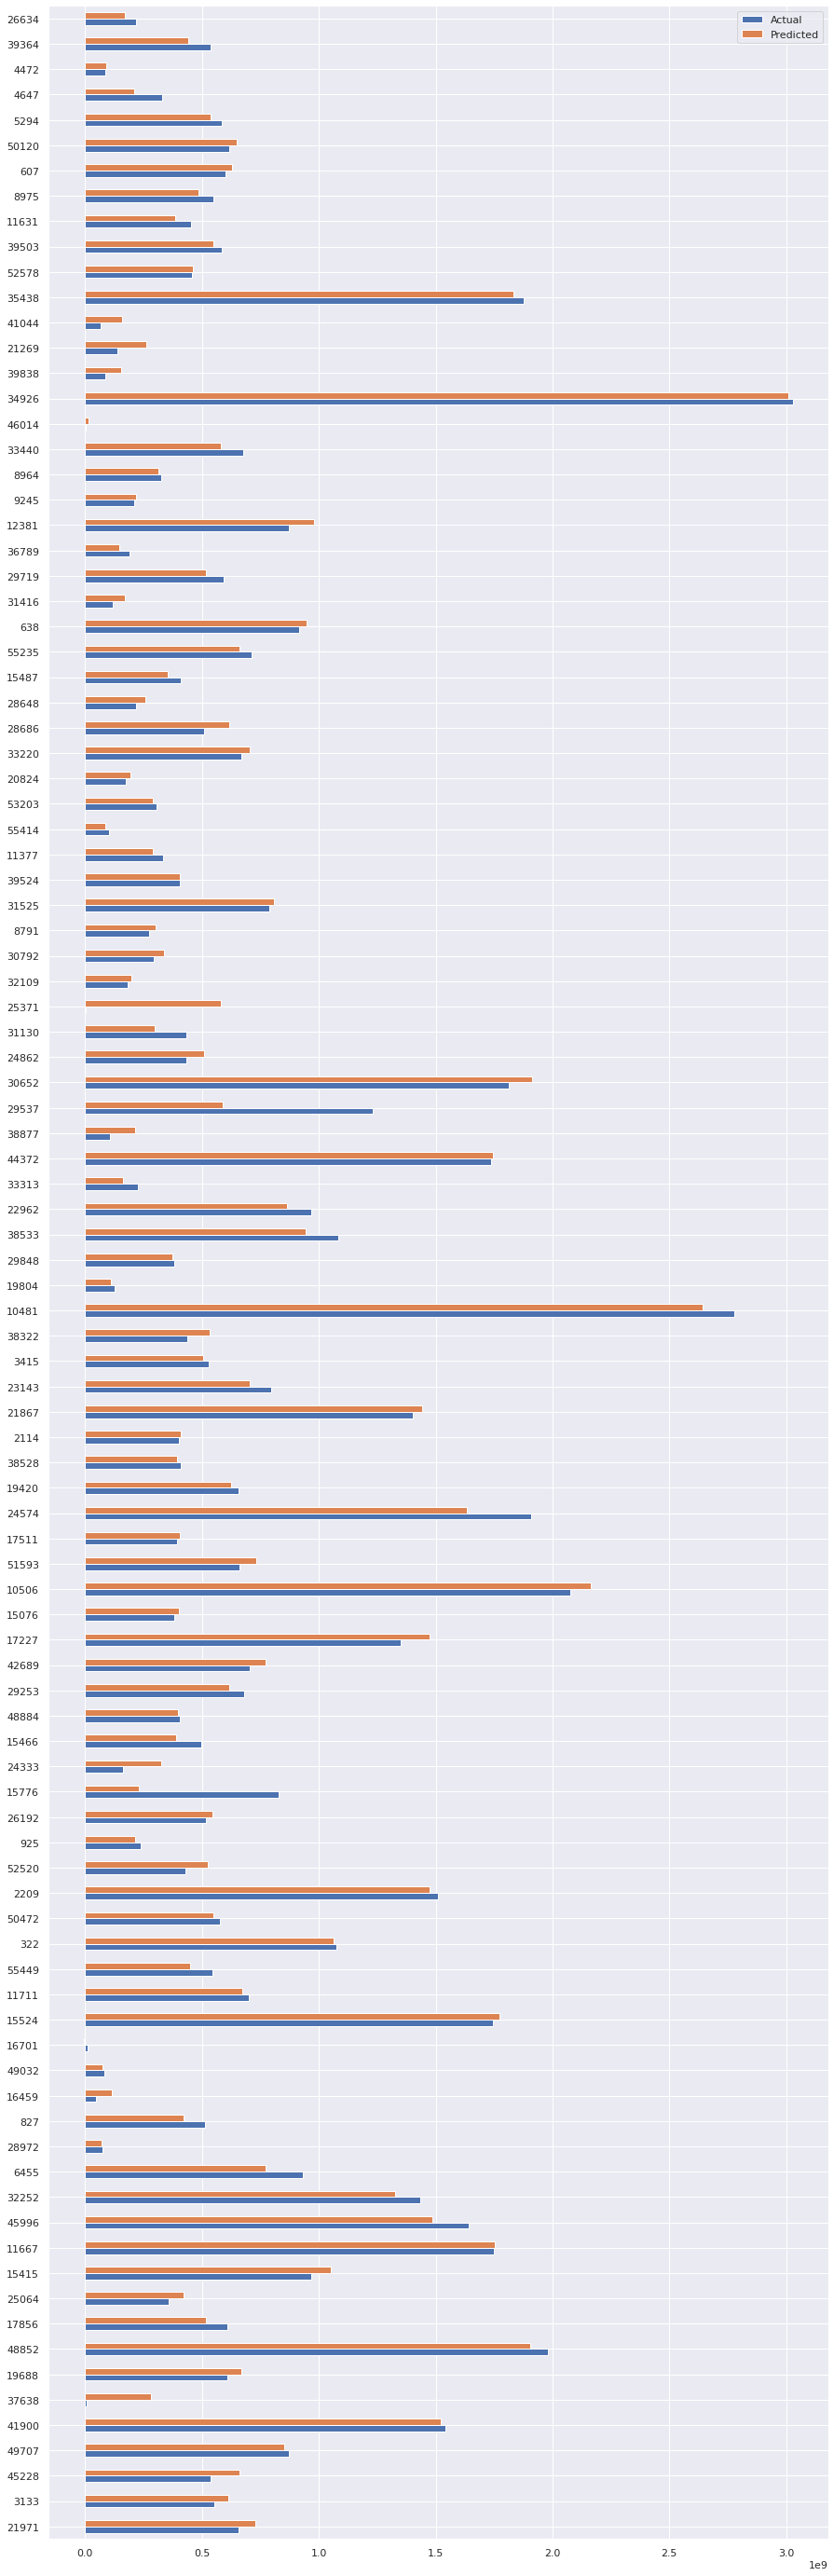

In [15]:
y_predicted = model.predict(X_test_scaled).flatten()
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
df_predicted.sample(100).plot(kind='barh',figsize=(15,50))
plt.show()